# Parse SLE images

In [1]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import random as rng
from matplotlib import pyplot as plt
import pandas as pd
import math
import os
from PIL import Image

## Inspect data

Let's inspect the data in our scanned images directory and one randomly chosen image.

In [2]:
directory = './data/synthetic_scanned_sles'
rand_index = np.random.randint(len(os.listdir(directory)))

rand_filename = os.listdir(directory)[rand_index]
#rand_filename = 'sle_synthetic_2020-10-21-18-13-08780.jpg'
src = cv.imread(os.path.join(directory, rand_filename))
image = src.copy()
print(f"{len(os.listdir(directory))} files in diectory {directory}")
print(f"{os.listdir(directory)[:5]} ...")

31 files in diectory ./data/synthetic_scanned_sles
['sle_image_annotations.csv', 'sle_synthetic_2020-10-23-15-01-06539.jpg', 'sle_synthetic_2020-10-23-15-01-07601.jpg', 'sle_synthetic_2020-10-23-15-01-09654.jpg', 'sle_synthetic_2020-10-23-15-01-1078.jpg'] ...


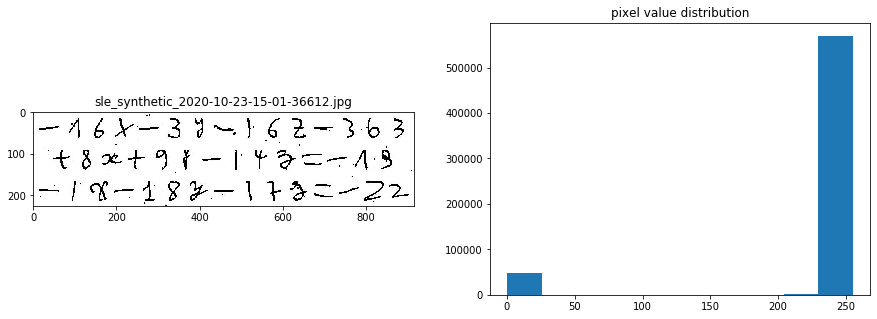

image shape: height 225, width 915, channels 3


In [3]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].imshow(image)
axes[0].set_title(rand_filename)
axes[1].hist(image.flatten())
axes[1].set_title("pixel value distribution")
plt.show()
print(f"image shape: height {image.shape[0]}, width {image.shape[1]}, channels {image.shape[2]}")

Load the information stored in the annotations csv.

In [4]:
#parse annotations
def parse_annotations(csv_file):
    df = pd.read_csv(csv_file, delimiter = ";", header = None, names =  ['file', 'n_rows', 'n_symbols', 'symbols', 'A', 'b', 'x', 'dilation', 'n_fragments', 'fragment_size'], index_col = 'file')
    
    return df

csv_filename = 'sle_image_annotations.csv'
annotations = parse_annotations(os.path.join(directory, csv_filename))
annotations.head()

,n_rows,n_symbols,symbols,A,b,x,dilation,n_fragments,fragment_size
file,,,,,,,,,
sle_synthetic_2020-10-23-15-01-06539.jpg,3,"[15, 14, 15]","[[-, 2, x, -, 1, 0, y, +, 2, z, =, -, 1, 7, 2]...","[[ -2 -10 2], [ -1 -8 11], [ 1 15 -17]]",[-172 -81 156],[16 15 5],3,100,5
sle_synthetic_2020-10-23-15-01-07601.jpg,3,"[14, 16, 16]","[[-, 4, x, +, 1, 6, y, -, 8, z, =, 3, 8, 0], [...","[[ -4 16 -8], [ 15 3 16], [ 11 -11 -14]]",[ 380 -263 137],[ 1 14 -20],3,100,5
sle_synthetic_2020-10-23-15-01-09654.jpg,3,"[16, 15, 15]","[[-, 8, x, +, 1, 0, y, -, 1, 4, z, =, -, 5, 3,...","[[ -8 10 -14], [ -9 -7 -18], [ 0 -20 -11]]",[-536 -347 144],[ 19 -16 16],3,100,5
sle_synthetic_2020-10-23-15-01-1078.jpg,3,"[15, 15, 13]","[[-, 1, 8, x, +, 7, y, +, 1, 9, z, =, -, 5, 0]...","[[-18 7 19], [ -5 17 13], [-18 5 5]]",[-50 127 74],[ -3 15 -11],3,100,5
sle_synthetic_2020-10-23-15-01-1218.jpg,3,"[13, 14, 15]","[[+, 0, x, -, 9, y, +, 8, z, =, -, 6, 9], [+, ...","[[ 0 -9 8], [ 0 -12 4], [-18 9 9]]",[ -69 -72 -234],[14 5 -3],3,100,5


In [5]:
annotations.loc[rand_filename, :]

n_rows                                                           3
n_symbols                                             [15, 14, 15]
symbols          [[-, 1, 6, x, -, 3, y, -, 1, 6, z, =, 3, 6, 3]...
A                    [[-16  -3 -16], [  8   9 -14], [ -1 -18 -17]]
b                                                    [363 -19 -22]
x                                                    [-19   7  -5]
dilation                                                         3
n_fragments                                                    100
fragment_size                                                    5
Name: sle_synthetic_2020-10-23-15-01-36612.jpg, dtype: object

## Transform and clean image

### Convert to binary image

Convert image to single channel with pixel values either 0 or 255.

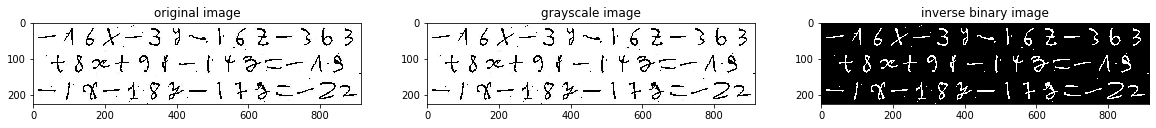

image_orig shape: (225, 915, 3)
image_gray shape: (225, 915)
image_threshed shape: (225, 915)
unique pixel values: [  0 255]


In [6]:
def transform_image(image, plot = False):
    """convert to grayscale for thresholding and then to binary image"""
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    ret, image_threshed = cv.threshold(image_gray, 150, 255, cv.THRESH_OTSU + cv.THRESH_BINARY_INV)
    
    if plot:
        fig, axes = plt.subplots(1,3, figsize = (20,40))
        axes[0].imshow(image)
        axes[0].set_title("original image")
        axes[1].imshow(image_gray, cmap = "gray")
        axes[1].set_title("grayscale image")
        axes[2].imshow(image_threshed, cmap = "gray")
        axes[2].set_title("inverse binary image")
        plt.show()
  
    print(f"image_orig shape: {image.shape}")
    print(f"image_gray shape: {image_gray.shape}")
    print(f"image_threshed shape: {image_threshed.shape}")
    print(f"unique pixel values: {np.unique(image_threshed)}")
        
    return image_threshed

image_transformed = transform_image(image, plot = True)

### Remove fragments from image

Most images contain some sort of fragments. Dust or particels on camera lenses, sensor or on the scanned sheet of paper itself result in these dark spots in the image. It shoudl be able to identify them as small contours with an area well below the mean are value of all contours.

only parent contours are inspected
indices of areas dropped [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 20, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 48, 51, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 78, 79, 81, 82, 83, 95, 96, 97]


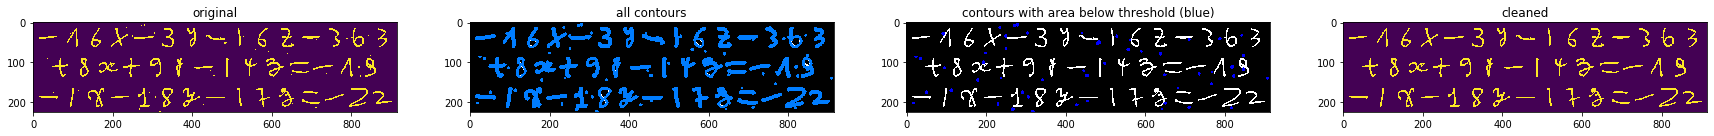

In [7]:
def remove_fragments(image, fraction = 0.1, plot = False, debug = False):
    """removes unwanted ragments from an image identified by their area in
    relation to the mean contour area of the whole image
    params:
        image: image array
        fraction: fraction of mean contour area used as threshold
    """
    
    print("only parent contours are inspected")
    contours, hierarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    
    #show all found contours
    image_all_contours = image.copy()
    image_all_contours = np.expand_dims(image_all_contours, axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        image_all_contours = cv.drawContours(image_all_contours, contours, k, (0, 125, 255), math.ceil(image.shape[0]/50))
        
    #create prefilled mask
    mask = np.ones(image.shape[:2], dtype="uint8")
    
    #show small contours
    contour_areas = []
    power = 1
    for c, contour in enumerate(contours):
        contour_areas.append(cv.contourArea(contour) / image.shape[0] / image.shape[1])
    
    contour_areas_p = fraction * np.mean(np.array(contour_areas))
    
    if debug:
        print(f" {fraction}% of mean used to cut areas below this value ({contour_areas_p})")
        print(f"{power} power of contour area used for thresholding")
    
    image_small_contours = image.copy()
    image_small_contours = np.expand_dims(image_small_contours, axis=2).repeat(3, axis=2) 
    
    dropped_indices = []
    for c, contour in enumerate(contours):
        if((cv.contourArea(contour) / image.shape[0] / image.shape[1]) ** power < contour_areas_p):
            dropped_indices.append(c)
            image_small_contours = cv.drawContours(image_small_contours, contours, c, (0, 0, 255), math.ceil(image.shape[0]/50))
            #add the unwanted contours
            cv.drawContours(mask, [contour], -1, 0, -1)
    print(f"indices of areas dropped {dropped_indices}")
    
    #apply the mask
    image_cleaned = cv.bitwise_and(image, image, mask = mask)
    
    if plot:
        #plt.boxplot(np.array(contour_areas) ** power)
        #plt.axhline(y=contour_areas_p)
        #plt.title(f"distribution of contour areas power {power}")
        #plt.show()

        fig, axes = plt.subplots(1,4, figsize = (30,20))
        axes[0].imshow(image)
        axes[0].set_title("original")
        axes[1].imshow(image_all_contours)
        axes[1].set_title("all contours")
        axes[2].imshow(image_small_contours)
        axes[2].set_title("contours with area below threshold (blue)")
        axes[3].imshow(image_cleaned)
        axes[3].set_title("cleaned")
        plt.show()
    
    return image_cleaned

image_cleaned = remove_fragments(image_transformed, fraction = 0.2, plot = True )

## Find the lines of the linear equation system

Now extract upper and lower horizontal borders of the single equations. An upper border is a line (one value in histogram) where the value is lower than a predefined threshold `threshold` and the next line has a value > `threshold`

[11, 88, 163]
[63, 138, 213]
3 row border pairs were found
[(11, 63), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 902)]


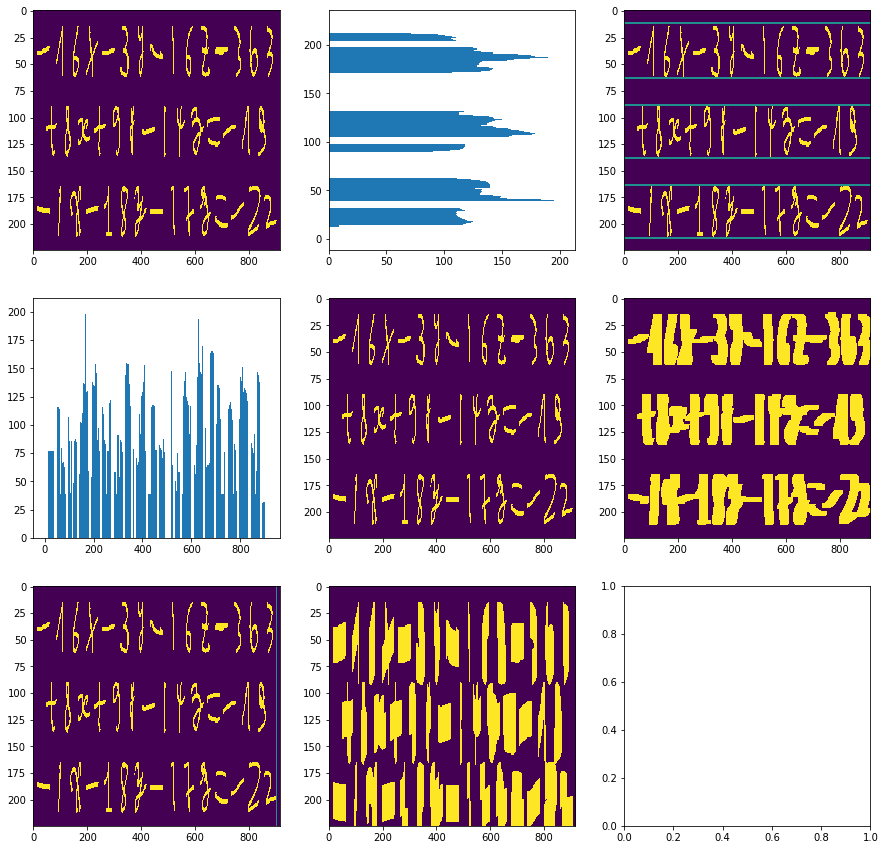

In [8]:
def find_borders(image, threshold = 1, dilation = 0, padding = 0, plot = False):
    """find borders in an image. An upper border is a line (one value in histogram) 
    where the value is lower than a predefined threshold `threshold` and 
    the next line has a value > `threshold`
    The image can be dilated. In combination with a higher threshold value dilation can
    ensure that only borders dividing very dense areas from nearly blank areas are found.
    Otherwise fractals in blank areas would create borders too.
    params:
        image: image array
        threshold: threshold value see above
        dilation: dilation steps to perform before identifiying borders
        padding: amount of pixels to add to the borders (increases later extracted line images)
    """

    image_local = image.copy()
    #only dilate in x direction
    kernel = np.ones([1,2])
    image_dilated_x = cv.dilate(image_local, kernel, iterations = dilation)
    
    #only dilate in y direction
    kernel = np.ones([2,1])
    image_dilated_y = cv.dilate(image_local, kernel, iterations = dilation)
    
    hist_row = cv.reduce(image_dilated_x, 1, cv.REDUCE_AVG).reshape(-1)
    hist_col = cv.reduce(image_dilated_y, 0, cv.REDUCE_AVG).reshape(-1)
    
    borders_0_row = [i - padding for i in range(len(hist_row)-1)  if hist_row[i] <= threshold and hist_row[i+1] >  threshold]
    borders_1_row = [i + padding for i in range(len(hist_row)-1)  if hist_row[i] > threshold and hist_row[i+1] <= threshold]
    print(borders_0_row)
    print(borders_1_row)
    
    borders_0_col = [i for i in range(len(hist_col)-1)  if hist_col[i] <= threshold and hist_col[i+1] > threshold]
    borders_1_col = [i for i in range(len(hist_col)-1)  if hist_col[i] > threshold and hist_col[i+1] <= threshold]
    
    #if dimension == 0 and len(borders_0) > 1:
    if len(borders_0_col) > 1:
        borders_0_col = [borders_0_col[0]]
        borders_1_col = [borders_1_col[-1]]
        
    #print(f"borders found for dimension {dimension} (0: vertical borders, 1 : horizontal borders)")
    print(f"{len(list(zip(borders_0_row, borders_1_row)))} row border pairs were found")
    print(list(zip(borders_0_row, borders_1_row)))
    print(f"{len(list(zip(borders_0_col, borders_1_col)))} col border pairs were found")
    print(list(zip(borders_0_col, borders_1_col)))
    
    borders_all_row = borders_0_row + borders_1_row
    borders_all_col = borders_0_col + borders_1_col
    image_borders_row = image.copy()
    image_borders_col = image.copy()
    image_borders_all = image.copy()
    
    line_width = math.ceil(image.shape[1]/500)
    #print(line_width)
    for border in borders_all_row:
        for i in range(line_width):
            image_borders_row[min(image.shape[0] - 1, border + i),:] = 128
            #image_borders_all[max(image.shape[0]border + i,:] = 128
            
    for border in borders_all_col:
        for i in range(line_width):
            image_borders_col[:, min(image.shape[1] - 1, border + i)] = 128
            #image_borders_all[:,border + i] = 128

    #plotting    
    if plot:
        fig, axes = plt.subplots(3,3, figsize=(15, 15))

        axes[0][1].barh(range(len(hist_row)), hist_row)
        axes[1][0].bar(range(len(hist_col)), hist_col)
        axes[0][0].imshow(image_local, aspect = "auto")
        axes[0][2].imshow(image_borders_row, aspect = "auto")
        axes[2][0].imshow(image_borders_col, aspect = "auto")
        axes[1][1].imshow(image_borders_all, aspect = "auto")
        axes[1][2].imshow(image_dilated_x, aspect = "auto")
        axes[2][1].imshow(image_dilated_y, aspect = "auto")
        plt.show()
    
    assert len(borders_0_row) + len(borders_1_row), 'no row borders found'
    assert len(borders_0_row) == len(borders_1_row), 'uneven number of row borders'
    assert len(borders_0_col) + len(borders_1_col), 'no col borders found'
    assert len(borders_0_col) == len(borders_1_col), 'uneven number of col borders'
    
    return (list(zip(borders_0_col,borders_1_col)), list(zip(borders_0_row,borders_1_row)))

#test
borders_x, borders_y = find_borders(image_cleaned, threshold = 1, dilation = 30, padding = 1, plot = True)   

Now extract the equations.

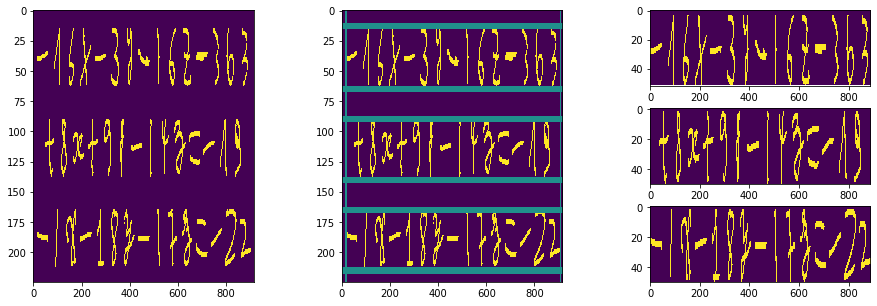

In [9]:
def extract_sections(image, borders_x, borders_y, plot = False):
    """
    params:
        image: image array
        borders_x, boders_y: pixel values as locations of lower/upper and
        left/right borders used for cutting the sections
    returns: 
        list of section coordinates as tuples (y1, y2, x1, x2)
    """
    line_width = math.ceil(image.shape[1]/200)
    image_borders = image.copy()
    x1, x2 = borders_x[0]
    for i in range(line_width):
        image_borders[:, min(x1 + i, image.shape[1] - 1)] = 128
        image_borders[:, min(x2 + i, image.shape[1] - 1)] = 128
    
    sections = []
    
    for borders in borders_y:
        y1, y2 = borders
        sections.append(image[y1:y2,x1:x2])
        for i in range(line_width):
            image_borders[min(y1 + i, image.shape[0] - 1),:] = 128
            image_borders[min(y2 + i, image.shape[0] - 1),:] = 128
            
    #plot
    if plot:
        fig = plt.figure(figsize = (15, 5))
        grid = plt.GridSpec(len(borders_y), 3, wspace = 0.4, hspace = 0.3, figure = fig)
        plt.subplot(grid[:len(borders_y), 0])
        plt.imshow(image, aspect = "auto")
        plt.subplot(grid[:len(borders_y), 1])
        plt.imshow(image_borders, aspect = "auto")
        for i in range(len(borders_y)):
            plt.subplot(grid[i, 2])
            plt.imshow(sections[i], aspect = "auto")

        plt.show()
    
    return sections

sections = extract_sections(image_cleaned, borders_x, borders_y, plot = True)

## Extract figures for each equation

Similar to removing small fragments we find the single figures via openCVs findcontours feature.

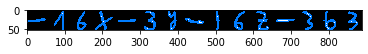

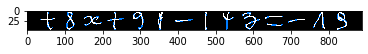

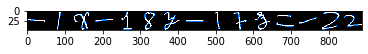

In [10]:
#find the contours
def plot_contour_image(image):
    contours,hierarchy = cv.findContours(image,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    image_all_contours = image.copy()
    image_all_contours = np.expand_dims(image_all_contours, axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        image_all_contours = cv.drawContours(image_all_contours, contours, k, (0, 125, 255), math.ceil(image.shape[0]/50))
    plt.imshow(image_all_contours)
    plt.show()
    
    return


for i, section in enumerate(sections):
    plot_contour_image(section) 

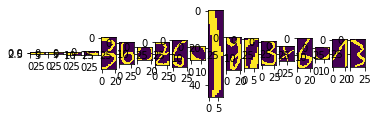

In [11]:
def plot_contours(image):
    """
    image: 2D array
    """
    image_copy = image.copy()
    contours, hierarchy = cv.findContours(image_copy,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    #print(hierarchy)
    n = len(contours)
    fig, axes = plt.subplots(1,n)
    
    for i in range(n):
        contour = contours[i]

        x_coords = [coord[0][0] for coord in contour]
        y_coords = [coord[0][1] for coord in contour]
       
        increase = 0
        #TODO check if <0 or größer Bild y
        x1 = min(x_coords) - increase
        x2 = max(x_coords) + increase
        y1 = min(y_coords) - increase
        y2 = max(y_coords) + increase

        image_contour = image[y1:y2,x1:x2]
        axes[i].imshow(image_contour)
    
    plt.show()

plot_contours(sections[0])    

Okay, there might a problem with e.g. the equal sign, use dilation to get only a single area that can be found via contours, then apply those contour coordinates on the original image pre dilation.

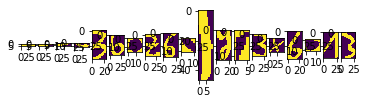

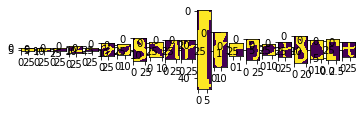

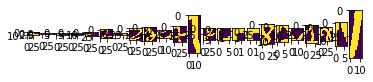

In [12]:
#dilation
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2))

for i, section in enumerate(sections):
    image_dilation = cv.dilate(section,kernel,iterations = 2)
    plot_contours(image_dilation)

15 figures found
[240, 660, 0, 420, 852, 785, 608, 550, 500, 373, 309, 181, 132, 71, 730]
15
15


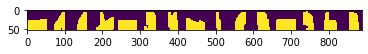

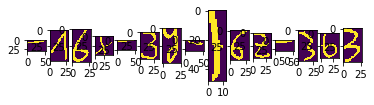

14 figures found
[390, 690, 150, 630, 570, 820, 758, 518, 470, 345, 280, 212, 103, 34]
14
14


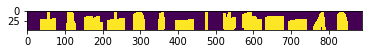

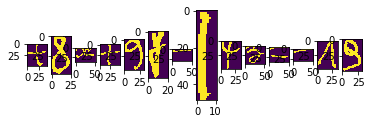

15 figures found
[420, 180, 0, 720, 840, 660, 780, 603, 546, 497, 361, 310, 249, 123, 78]
15
15


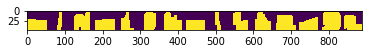

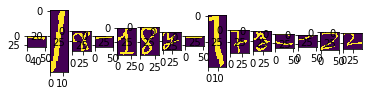

In [13]:
def extract_figures(image, dila_iterations_x = 1, dila_iterations_y = 1,
                    contour_thresh = 1, pixel_increase = 0, plot = False):
    """ extract a single image for each symbol in the line images. The areas resembling the symbols
    are found via contours (borders of areas of same pixel values)
    params:
        image: image array
        dila_iterations: number of dilation iterations used
        contour_tresh: minimum contour area a contour must have to be extracted
        pixel_increase: some padding for the extracted image
    returns: list of 2D image matrices sorted by their horizontal position in the image
    """
    
    kernel_x = np.ones([1,2])
    image_dilation = cv.dilate(image, kernel_x, iterations = dila_iterations_x)
    
    kernel_y = np.ones([2,1])
    image_dilation = cv.dilate(image_dilation, kernel_y, iterations = dila_iterations_y)
    
    #cv.RETR_EXTERNAL, only parents, all childs are discarded
    contours,hierarchy = cv.findContours(image_dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    images_figures = []
    images_coords = []
    image_height, image_width  = image.shape
    
    for contour in contours:

        if(cv.contourArea(contour)**2 > contour_thresh):
            x_coords = [coord[0][0] for coord in contour]
            y_coords = [coord[0][1] for coord in contour]

            x1 = max(min(x_coords) - pixel_increase, 0)
            x2 = min(max(x_coords) + pixel_increase, image_width)
            y1 = max(min(y_coords) - pixel_increase, 0)
            y2 = min(max(y_coords) + pixel_increase, image_height)

            images_figures.append(image[y1:y2,x1:x2])
            images_coords.append([x1,x2,y1,y2])
    
    print(f"{len(images_figures)} figures found")
        
    #sort
    x1s = [coord[0] for coord in images_coords]
    print(x1s)
    zipped = sorted(zip(x1s,images_figures))
    print(len(x1s))
    print(len(images_figures))
    images_figures_sorted = [image for _, image in (sorted(zip(x1s,images_figures)))]
    
    if plot:
        plt.imshow(image_dilation)
        fig, axes = plt.subplots(1,len(images_figures_sorted))
        for i, figure  in enumerate(images_figures_sorted):
            axes[i].imshow(figure)
            
        plt.show()
        
    return images_figures_sorted

images_figures_sorted = extract_figures(sections[0], 3, 30, 10, 1, plot = True)
images_figures_sorted = extract_figures(sections[1], 3, 30, 10, 1, plot = True)
images_figures_sorted = extract_figures(sections[2], 3, 30, 10, 1, plot = True)

15 figures found
[240, 660, 0, 420, 852, 785, 608, 550, 500, 373, 309, 181, 132, 71, 730]
15
15


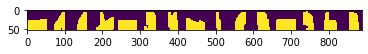

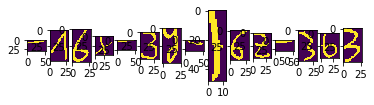

14 figures found
[390, 690, 150, 630, 570, 820, 758, 518, 470, 345, 280, 212, 103, 34]
14
14


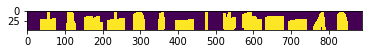

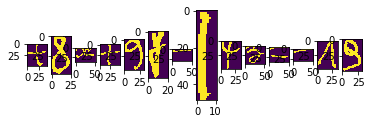

15 figures found
[420, 180, 0, 720, 840, 660, 780, 603, 546, 497, 361, 310, 249, 123, 78]
15
15


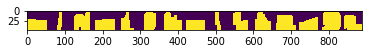

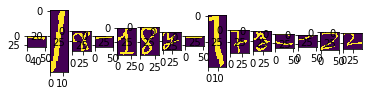

In [14]:
def create_figures_df(sections, dila_iterations_x = 1, dila_iterations_y = 1,
                      contour_thresh = 1, pixel_increase = 0, plot = False):
    """create a dataframe containing position (line and position in line) and
    image array data for each symbol
    for more information see extract_figures function
    params:
        sections: borders of sections to be extracted
        dila_iterations: number of dilation iterations used
        contour_tresh: minimum contour area a contour must have to be extracted
        pixel_increase: some padding for the extracted image
    returns:
        pandas Dataframe
    """
    
    images = []
    positions = []
    lines = []
    for (i, section) in enumerate(sections):
        images_figures_sorted = extract_figures(section, dila_iterations_x, dila_iterations_y , contour_thresh, pixel_increase,  plot)
        for (j,one_image) in enumerate(images_figures_sorted):
            positions.append(j)
            lines.append(i)
            images.append(one_image)
    figures_df = pd.DataFrame( {'line' : lines, 'position' : positions, 'image' : images })
    figures_df.head()
    
    return figures_df

figures_df = create_figures_df(sections, 3, 30, 10, 1, plot = True)

## Preprocess figure images for processign with Neural Network

Kaggle handwritten images: 45x45
 -> resize to 28x28 (to be compatible to MNIST dataset in the future)


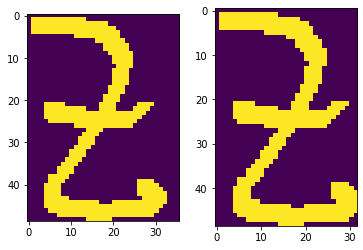

In [15]:
def remove_empty_rowscols(image,  plot = False):
    """removes all completely empty lines and columns at the edge of an image (padding)"""
    
    image_orig = image.copy()
        
    threshold = 2
    #first filled row
    row_0 = [i for i in range(0, image.shape[0]-1) if np.sum(image[i, :]) <= threshold and np.sum(image[i+1, :]) > threshold]
    row_1 = [i for i in range(0, image.shape[0]-1) if np.sum(image[i, :]) >= threshold and np.sum(image[i+1, :]) < threshold]
              
    if row_0:
        row_0 = min(row_0)
        image = np.delete(image,range(0, row_0),0)
        
    if row_1:
        row_1 = max(row_1)
        image = np.delete(image,range(row_1,image.shape[0]),0)
        
    col_0 = [i for i in range(0, image.shape[1]-1)  if np.sum(image[:, i]) <= threshold and np.sum(image[:, i + 1]) > threshold]
    col_1 = [i for i in range(0, image.shape[1]-1)  if np.sum(image[:, i]) >= threshold and np.sum(image[:, i + 1]) < threshold]
    
    if col_0:
        col_0 = min(col_0)
        image = np.delete(image, range(0, col_0), 1)
        
    if col_1:
        col_1 = max(col_1)
        image = np.delete(image, range(col_1, image.shape[1]), 1)
        
    if plot: 
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(image_orig)
        axes[1].imshow(image)
        plt.show()
    
    return image

#test
_ = remove_empty_rowscols(figures_df.loc[10,'image'], plot = True)

In [16]:
figures_df['image'] = figures_df['image'].apply(remove_empty_rowscols)

now transform to 20x20 center of 28x28 binary image

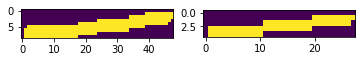

In [17]:
def resize_28x28(image, plot = False):
    """resize to 28x28 pixel image preserving asepct ratio"""
    
    image_orig = image.copy()
    
    #important: preserve AR! -> resize dimension with higher size to 20, other will be <=20
    #ascpect ratio = width/height
    n_cols = image.shape[1]
    n_rows = image.shape[0]
    
    n_rows_new = 28
    n_cols_new = 28
    
    if (n_cols > n_rows):
        ar = float(n_cols) / n_rows
        n_rows_new = int(n_cols_new / ar)
    else:
        ar = float(n_cols) / n_rows
        n_cols_new = int(n_rows_new * ar)
        
    image = cv.resize(image,(n_cols_new, n_rows_new))
    
    ret, image = cv.threshold(image, 200, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    if plot:
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(image_orig)
        axes[1].imshow(image)
        plt.show()
    
    return image

#TO DO maybe interpolation method if zooming other if shrinking
_ = resize_28x28(figures_df.loc[0,'image'], plot = True)
figures_df['image'] = figures_df['image'].apply(resize_28x28)

now add black padding to get 28x28 pixels

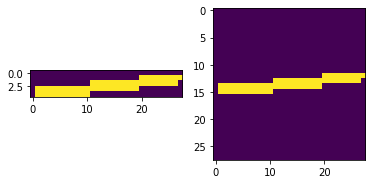

In [18]:
def pad_fill(image, target_size, fill_value = 0, plot = False):
    """add padding to resize to a quadratic image file
    params:
        image: image array
        target_size: width/height of returned image
        fill_value: added pixels will be filled with this value
    """
    image_orig = image.copy() 
    target_mat = np.full(
        shape=target_size,
        fill_value=fill_value,
        dtype=np.int)
    
    pad_x = (target_size[1] - image.shape[1]) / 2.0
    pad_y = (target_size[0] - image.shape[0]) / 2.0
    
    target_mat[math.floor(pad_y) : target_size[0] - math.ceil(pad_y),
               math.floor(pad_x) : target_size[1] - math.ceil(pad_x)] = image
    image = target_mat
    
    if plot:
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(image_orig)
        axes[1].imshow(image)
        plt.show()
    
    return image

#test
_ = pad_fill(figures_df.loc[0,'image'], (28,28), 0, plot = True)

In [19]:
figures_df['image'] = figures_df['image'].apply(pad_fill, args = ((28,28), 0))
print(figures_df.head())
print(figures_df.info())

   line  position                                              image
0     0         0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1     0         1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2     0         2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3     0         3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4     0         4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   line      44 non-null     int64 
 1   position  44 non-null     int64 
 2   image     44 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


## Export images

In [20]:
directory = './data/sle_symbols_parsed'
os.makedirs(directory, exist_ok = True)

def save_image_from_df(row, directory, filename = None):
    """saves images stored in a dataframe as single files in one folder"""
    os.makedirs(directory, exist_ok = True)
    image = Image.fromarray(row['image'])
    image = image.convert( 'RGB')
    
    if filename:
        os.makedirs(os.path.join(directory, filename.replace('.jpg', '')), exist_ok = True)
        image.save(os.path.join(directory, filename.replace('.jpg', ''), str(row['line']) + '_' + str(row['position']) + '.jpg'))
        
    else:
        image.save(os.path.join(directory, str(row['line']) + '_' + str(row['position']) + '.jpg'))

### Parse a bunch of images

In [21]:
results = pd.DataFrame(columns = ['file', 'n_lines', 'n_sym_line', 'n_symbols', 'n_lines_f', 'n_sym_line_f', 'n_symbols_f' ])
annotations.head()

,n_rows,n_symbols,symbols,A,b,x,dilation,n_fragments,fragment_size
file,,,,,,,,,
sle_synthetic_2020-10-23-15-01-06539.jpg,3,"[15, 14, 15]","[[-, 2, x, -, 1, 0, y, +, 2, z, =, -, 1, 7, 2]...","[[ -2 -10 2], [ -1 -8 11], [ 1 15 -17]]",[-172 -81 156],[16 15 5],3,100,5
sle_synthetic_2020-10-23-15-01-07601.jpg,3,"[14, 16, 16]","[[-, 4, x, +, 1, 6, y, -, 8, z, =, 3, 8, 0], [...","[[ -4 16 -8], [ 15 3 16], [ 11 -11 -14]]",[ 380 -263 137],[ 1 14 -20],3,100,5
sle_synthetic_2020-10-23-15-01-09654.jpg,3,"[16, 15, 15]","[[-, 8, x, +, 1, 0, y, -, 1, 4, z, =, -, 5, 3,...","[[ -8 10 -14], [ -9 -7 -18], [ 0 -20 -11]]",[-536 -347 144],[ 19 -16 16],3,100,5
sle_synthetic_2020-10-23-15-01-1078.jpg,3,"[15, 15, 13]","[[-, 1, 8, x, +, 7, y, +, 1, 9, z, =, -, 5, 0]...","[[-18 7 19], [ -5 17 13], [-18 5 5]]",[-50 127 74],[ -3 15 -11],3,100,5
sle_synthetic_2020-10-23-15-01-1218.jpg,3,"[13, 14, 15]","[[+, 0, x, -, 9, y, +, 8, z, =, -, 6, 9], [+, ...","[[ 0 -9 8], [ 0 -12 4], [-18 9 9]]",[ -69 -72 -234],[14 5 -3],3,100,5


In [22]:
directory = './data/synthetic_scanned_sles'
os.makedirs(directory, exist_ok = True)

annotations = parse_annotations(os.path.join(directory, 'sle_image_annotations.csv'))

results = pd.DataFrame(columns = ['file', 'n_lines', 'n_sym_line', 'n_symbols', 'n_lines_f', 'n_sym_line_f', 'n_symbols_f' ])

n = 2000

for filename in annotations.index[:min(n, len(os.listdir(directory)))]:
    try:
        print(filename)
        print(os.path.join(directory, filename))
        src = cv.imread(os.path.join(directory, filename))
        image = src.copy()

        plot = False

        if plot:
            plt.imshow(image)
            plt.show()

        #parse it
        image_transformed = transform_image(image)
        image_cleaned = remove_fragments(image_transformed, fraction = 0.2)
        borders_x, borders_y = find_borders(image_cleaned, threshold = 1, dilation = 30, padding = 1, plot = plot) 
        sections = extract_sections(image_cleaned, borders_x, borders_y)
        figures_df = create_figures_df(sections, 3, 30, 10, 1, plot = plot)
        figures_df['image'] = figures_df['image'].apply(remove_empty_rowscols)
        figures_df['image'] = figures_df['image'].apply(resize_28x28)
        figures_df['image'] = figures_df['image'].apply(pad_fill, args = ((28,28), 0))
        figures_df.info()

        #save to files
        parse_directory = './data/sle_symbols_parsed'
        figures_df.apply(lambda row : save_image_from_df(row, parse_directory, filename), axis = 1)

        #calc some aggregates for comparison with original images
        n_lines_found = len(figures_df['line'].unique())
        n_symbols_per_line_found = list(figures_df.groupby(['line']).count().loc[:, 'image'].values)
        n_symbols_found = sum(n_symbols_per_line_found)


        n_lines = annotations.loc[filename, 'n_rows']
        n_symbols_per_line = eval(annotations.loc[filename, 'n_symbols'])
        n_symbols = sum(n_symbols_per_line)

        series = pd.Series({'file' : filename, 'n_lines' : n_lines, 'n_sym_line' : n_symbols_per_line, 'n_symbols' : n_symbols ,
                            'n_lines_f' : n_lines_found, 'n_sym_line_f' : n_symbols_per_line_found, 'n_symbols_f' : n_symbols_found  })
        series = series.to_frame().T
        results = results.append(series)
    except:
        print("some error occured while parsing an image, continue with the next image")
    

sle_synthetic_2020-10-23-15-01-06539.jpg
./data/synthetic_scanned_sles\sle_synthetic_2020-10-23-15-01-06539.jpg
image_orig shape: (225, 915, 3)
image_gray shape: (225, 915)
image_threshed shape: (225, 915)
unique pixel values: [  0 255]
only parent contours are inspected
indices of areas dropped [0, 1, 2, 4, 5, 6, 8, 9, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 46, 48, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 79, 82, 85, 94, 95, 96]
[12, 88, 163]
[65, 138, 213]
3 row border pairs were found
[(12, 65), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 902)]
15 figures found
[180, 0, 660, 600, 840, 540, 420, 790, 738, 487, 368, 305, 261, 125, 61]
15
15
14 figures found
[690, 210, 30, 630, 570, 829, 759, 514, 461, 391, 342, 277, 158, 106]
14
14
15 figures found
[420, 660, 120, 780, 60, 848, 724, 603, 552, 484, 374, 301, 258, 183, 2]
15
15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 co

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   line      42 non-null     int64 
 1   position  42 non-null     int64 
 2   image     42 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.1+ KB
sle_synthetic_2020-10-23-15-01-17311.jpg
./data/synthetic_scanned_sles\sle_synthetic_2020-10-23-15-01-17311.jpg
image_orig shape: (225, 915, 3)
image_gray shape: (225, 915)
image_threshed shape: (225, 915)
unique pixel values: [  0 255]
only parent contours are inspected
indices of areas dropped [0, 1, 2, 4, 7, 8, 9, 10, 12, 13, 16, 27, 28, 29, 30, 31, 32, 33, 38, 40, 41, 42, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 73, 74, 77, 78, 80, 90, 91, 92, 93, 94]
[13, 88, 163]
[63, 138, 213]
3 row border pairs were found
[(13, 63), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 888)]
14 figures found
[270, 30, 690, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   line      48 non-null     int64 
 1   position  48 non-null     int64 
 2   image     48 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
sle_synthetic_2020-10-23-15-01-28858.jpg
./data/synthetic_scanned_sles\sle_synthetic_2020-10-23-15-01-28858.jpg
image_orig shape: (225, 915, 3)
image_gray shape: (225, 915)
image_threshed shape: (225, 915)
unique pixel values: [  0 255]
only parent contours are inspected
indices of areas dropped [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 18, 21, 22, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 54, 55, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 83, 93]
[13, 88, 163]
[63, 138, 213]
3 row border pairs were found
[(13, 63), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 894)]
12 figures found
[90, 690, 270

image_orig shape: (225, 975, 3)
image_gray shape: (225, 975)
image_threshed shape: (225, 975)
unique pixel values: [  0 255]
only parent contours are inspected
indices of areas dropped [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 16, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 46, 47, 48, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 77, 78, 79, 80, 81, 84, 85, 86, 98, 99]
[13, 88, 163]
[66, 138, 213]
3 row border pairs were found
[(13, 66), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 958)]
15 figures found
[690, 630, 750, 450, 879, 813, 575, 519, 397, 346, 274, 211, 151, 108, 30]
15
15
13 figures found
[510, 750, 450, 270, 818, 693, 637, 570, 394, 330, 214, 156, 93]
13
13
16 figures found
[0, 720, 660, 780, 903, 849, 604, 552, 500, 424, 363, 313, 243, 181, 123, 69]
16
16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   line   

sle_synthetic_2020-10-23-15-01-50669.jpg
./data/synthetic_scanned_sles\sle_synthetic_2020-10-23-15-01-50669.jpg
image_orig shape: (225, 975, 3)
image_gray shape: (225, 975)
image_threshed shape: (225, 975)
unique pixel values: [  0 255]
only parent contours are inspected
indices of areas dropped [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 14, 16, 17, 19, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 55, 57, 61, 71, 72, 73, 74, 75, 76, 78, 79, 82, 84, 85, 86, 88, 89, 91, 101, 102, 103, 104, 105, 106]
[13, 88, 163]
[63, 138, 213]
3 row border pairs were found
[(13, 63), (88, 138), (163, 213)]
1 col border pairs were found
[(14, 956)]
14 figures found
[420, 60, 240, 300, 660, 848, 794, 740, 602, 541, 498, 371, 185, 128]
14
14
15 figures found
[450, 690, 150, 630, 871, 812, 750, 573, 521, 404, 337, 280, 211, 96, 34]
15
15
16 figures found
[720, 480, 240, 660, 0, 906, 855, 790, 612, 550, 426, 370, 310, 187, 131, 66]
16
16
<class 'pandas.core.frame.DataFrame'>
Range

In [23]:
results

,file,n_lines,n_sym_line,n_symbols,n_lines_f,n_sym_line_f,n_symbols_f
0,sle_synthetic_2020-10-23-15-01-06539.jpg,3,"[15, 14, 15]",44,3,"[15, 14, 15]",44
0,sle_synthetic_2020-10-23-15-01-07601.jpg,3,"[14, 16, 16]",46,3,"[14, 16, 16]",46
0,sle_synthetic_2020-10-23-15-01-09654.jpg,3,"[16, 15, 15]",46,3,"[16, 15, 15]",46
0,sle_synthetic_2020-10-23-15-01-1078.jpg,3,"[15, 15, 13]",43,3,"[15, 15, 13]",43
0,sle_synthetic_2020-10-23-15-01-1218.jpg,3,"[13, 14, 15]",42,3,"[13, 14, 15]",42
0,sle_synthetic_2020-10-23-15-01-142.jpg,3,"[15, 15, 15]",45,3,"[15, 15, 15]",45
0,sle_synthetic_2020-10-23-15-01-15712.jpg,3,"[12, 15, 15]",42,3,"[12, 15, 15]",42
0,sle_synthetic_2020-10-23-15-01-17311.jpg,3,"[14, 13, 15]",42,3,"[14, 13, 15]",42
0,sle_synthetic_2020-10-23-15-01-18270.jpg,3,"[14, 16, 14]",44,3,"[14, 16, 14]",44
0,sle_synthetic_2020-10-23-15-01-20427.jpg,3,"[16, 13, 13]",42,3,"[16, 13, 14]",43


In [24]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 0
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          30 non-null     object
 1   n_lines       30 non-null     object
 2   n_sym_line    30 non-null     object
 3   n_symbols     30 non-null     object
 4   n_lines_f     30 non-null     object
 5   n_sym_line_f  30 non-null     object
 6   n_symbols_f   30 non-null     object
dtypes: object(7)
memory usage: 1.9+ KB


## Evaluation

Let's check how many images were parsed correct. To do so an accuracy score can be used. 

$$
\frac{number of symbols per row parsed}{number of symbols per row in original image}
$$

In [25]:
#accuracy on SLEs (same number of rows and in each row same number of symbols)
accuracy = np.sum(results['n_sym_line'] == results['n_sym_line_f'])/len(results['n_sym_line'])
print(accuracy)

0.8666666666666667
